## tf.data API

This pipeline is used for fast reading and processing of input data

### Guidelines:

> 1) **from_generator**: When you want to use libs outside tensorflow for preprocessing (sklearn,numpy). Recommended for processing json, xml, csv datafiles which are not usually too large. Also make sure that the generator function is implemented in deployment code

> 2) **from_tensor_slices**: When each data is present in separate file and you want to benefit from parallelization in the I/O step

> 3) **TextLineData** : When a data element represents a line of text files

> 4) **Make CSV dataset**: Tensflow pipeline for CSV data. USe if you dont need sklearn/numpy pre processing

> 5) **FixedLengthRecordDataset**: When data is in a binary file and each sample is of fixed number of bytes


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
files_path = "datasets/VOC2007/JPEGImages/*.jpg"
filesname = glob.glob(files_path)
print(len(filesname))

9963


### 1) Using generator

> Easy to link python coded preprocessing. 

> The generator function returning np array is passed on to the Datasets API

In [3]:
#I still prefer tensorflow preprocessing, as it helps me control device placements
def process_image(im):
    with tf.device('/cpu:0'):
        image_tensor = tf.convert_to_tensor(im)
        float_image_tensor = tf.image.convert_image_dtype(image_tensor,tf.float32)
        #resize requires size to be knwown before hand, so we use it as part of generator.
        float_resized_image = tf.image.resize_images(float_image_tensor,(224,224))
        uint_resized_image = tf.image.convert_image_dtype(float_resized_image,tf.uint8)
        return uint_resized_image

def generate_images():
    #Do not use MUTABLE global variables inside generator
    #filesname is immutable
    for f in filesname:
        print("Fetching ", f)
        #It is not a bad idea to nest sessions here, as this will run in a separate thread
        yield tf.Session(config=tf.ConfigProto(log_device_placement=True)).run(process_image(Image.open(f)))
        

As much as possible,put all the data processing pipeline on the CPU to make sure that the GPU is only used for training the deep neural network model

Fetching  datasets/VOC2007/JPEGImages/008876.jpg


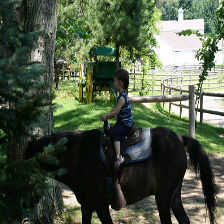

In [4]:
for im in generate_images():
    x = im
    break
Image.fromarray(x)    

**tf.data.Dataset.from_generator**

In [5]:
ds = tf.data.Dataset.from_generator(generate_images,tf.uint8,(224,224,3))

**Shuffling buffer** stores BUFFERSIZE elements in the buffer and randomly selects from them. Once the element is selected, it pushes the next element in the dataset into the buffer

In [6]:
BUFFERSIZE = 30 #Better to close to data size
NUM_EPOCHS = 10
ds = ds.shuffle(BUFFERSIZE)
ds = ds.repeat(NUM_EPOCHS)

Vectorize cheap user-defined functions passed in to the **map** transformation to amortize the overhead associated with scheduling and executing the function.

**Parallelize the map** transformation by setting the **num_parallel_calls** argument. We recommend using the number of available CPU cores for its value.

> **Note:** We use the resize preprocessing as a part of generator, because it requires the size of image to be known before hand. It also falls under the **I/O** (Yellow) region in the image below

<img src="pics/datasets_parallel_map.png" />

In [7]:
ds = ds.map(lambda x: tf.image.random_flip_left_right(x,seed=101),num_parallel_calls=2)

In [8]:
ds = ds.map(lambda x: tf.image.random_saturation(x,lower=0.2, upper=1.8),num_parallel_calls=2)

If you are combining pre-processed elements into a batch using the batch transformation, we recommend using the fused **map_and_batch** transformation; especially if you are using large batch sizes. (Although now we use them separately)

In [9]:
ds = ds.batch(10)

**Prefetching** is a technique used by computer processors to boost execution performance by fetching instructions or data from their original storage in slower memory to a faster local memory before it is actually needed

Use the **prefetch** transformation to overlap the work of a producer and consumer. In particular, we recommend adding prefetch(n) (where n is the number of elements / batches consumed by a training step) to the end of your input pipeline to overlap the transformations performed on the CPU with the training done on the accelerator.

**WITHOUT PREFETCHING**
<img src="pics/datasets_without_pipelining.png" />


**WITH PREFETCHING**
<img src="pics/datasets_with_pipelining.png" />

In [10]:
ds = ds.prefetch(1) #Max Number of batches that ll be prefetched, here just get next batch

In [11]:
iterator = ds.make_one_shot_iterator()

In [12]:
im_batch = iterator.get_next()

In [13]:
im_batch

<tf.Tensor 'IteratorGetNext:0' shape=(?, 224, 224, 3) dtype=uint8>

In [14]:
sess = tf.Session()
out = sess.run(im_batch)

Fetching  datasets/VOC2007/JPEGImages/008876.jpg
Fetching  datasets/VOC2007/JPEGImages/009815.jpg
Fetching  datasets/VOC2007/JPEGImages/005038.jpg
Fetching  datasets/VOC2007/JPEGImages/000825.jpg
Fetching  datasets/VOC2007/JPEGImages/003778.jpg
Fetching  datasets/VOC2007/JPEGImages/006692.jpg
Fetching  datasets/VOC2007/JPEGImages/001331.jpg
Fetching  datasets/VOC2007/JPEGImages/004375.jpg
Fetching  datasets/VOC2007/JPEGImages/004274.jpg
Fetching  datasets/VOC2007/JPEGImages/008054.jpg
Fetching  datasets/VOC2007/JPEGImages/007208.jpg
Fetching  datasets/VOC2007/JPEGImages/005078.jpg
Fetching  datasets/VOC2007/JPEGImages/006182.jpg
Fetching  datasets/VOC2007/JPEGImages/005648.jpg
Fetching  datasets/VOC2007/JPEGImages/007386.jpg
Fetching  datasets/VOC2007/JPEGImages/006981.jpg
Fetching  datasets/VOC2007/JPEGImages/002999.jpg
Fetching  datasets/VOC2007/JPEGImages/006095.jpg
Fetching  datasets/VOC2007/JPEGImages/003931.jpg
Fetching  datasets/VOC2007/JPEGImages/001646.jpg
Fetching  datasets/V

**prefetches 2 batches,fills shuffling buffer, but outputs only the required**

In [15]:
out.shape

(10, 224, 224, 3)

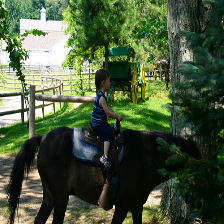

In [16]:
Image.fromarray(out[0])

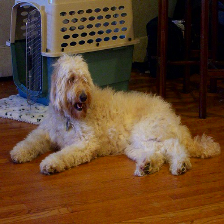

In [17]:
Image.fromarray(out[1])

In [18]:
out = sess.run(im_batch)

Fetching  datasets/VOC2007/JPEGImages/002357.jpg
Fetching  datasets/VOC2007/JPEGImages/000586.jpg
Fetching  datasets/VOC2007/JPEGImages/005568.jpg
Fetching  datasets/VOC2007/JPEGImages/005917.jpg
Fetching  datasets/VOC2007/JPEGImages/008700.jpg
Fetching  datasets/VOC2007/JPEGImages/007099.jpg
Fetching  datasets/VOC2007/JPEGImages/001259.jpg
Fetching  datasets/VOC2007/JPEGImages/007663.jpg
Fetching  datasets/VOC2007/JPEGImages/004585.jpg
Fetching  datasets/VOC2007/JPEGImages/007039.jpg


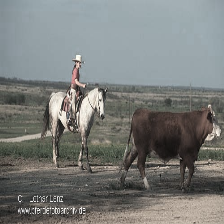

In [19]:
Image.fromarray(out[0])

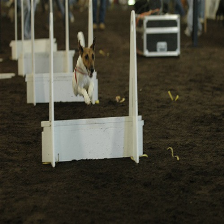

In [20]:
Image.fromarray(out[1])

### 2) Using from_tensor_slices

> **from_tensor_slices** creates a dataset with a separate element for each row of the input tensor (here filesname list is automatically casted to tensor)

> The resulting dataset consist of sequence of **string tensor**

> The further operations are done on a tenser. Hence, we are expected to **restrict to the tensorflow methods**

In [21]:
filesname[:5]

['datasets/VOC2007/JPEGImages/008876.jpg',
 'datasets/VOC2007/JPEGImages/009815.jpg',
 'datasets/VOC2007/JPEGImages/005038.jpg',
 'datasets/VOC2007/JPEGImages/000825.jpg',
 'datasets/VOC2007/JPEGImages/003778.jpg']

In [22]:
dataset = tf.data.Dataset.from_tensor_slices(filesname)

In [23]:
def read_jpg(filename):
    #filename is a string tensor. So tensorflow libs are expected to be used
    image_string = tf.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    return image

def resize_img(image_tensor):
    float_image_tensor = tf.image.convert_image_dtype(image_tensor,tf.float32)
    float_resized_image = tf.image.resize_images(float_image_tensor,(224,224))
    uint_resized_image = tf.image.convert_image_dtype(float_resized_image,tf.uint8)
    return uint_resized_image

In [24]:
dataset = dataset.map(read_jpg, num_parallel_calls=4)

In [25]:
dataset = dataset.map(resize_img,num_parallel_calls=4)

In [26]:
dataset = dataset.batch(100)

In [27]:
dataset = dataset.prefetch(1)

In [28]:
iterator = dataset.make_one_shot_iterator()

In [29]:
im_batch = iterator.get_next()

In [30]:
out = sess.run(im_batch)

In [31]:
out.shape

(100, 224, 224, 3)

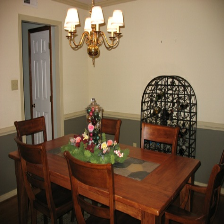

In [32]:
Image.fromarray(out[1])

### 3) When each line of your file is a data

In [33]:
dataset = tf.data.TextLineDataset("files/data_csv.csv")

In [34]:
dataset = dataset.map(lambda x: tf.string_split([x],delimiter=',').values)

In [35]:
iterator = dataset.make_one_shot_iterator()

In [36]:
next_el = iterator.get_next()

In [37]:
sess.run(next_el)

array([b'Country', b'Age', b'Salary', b'Purchased'], dtype=object)

In [38]:
sess.run(next_el)

array([b'France', b'44', b'72000', b'No'], dtype=object)

**Zipping data from multiple files**

In [39]:
features = tf.data.TextLineDataset("files/features.txt")
labels = tf.data.TextLineDataset("files/labels.txt")

In [40]:
dataset = tf.data.Dataset.zip((features,labels))

In [41]:
#def func(x,y):
#    ...

dataset = dataset.map(
    lambda x,y: (tf.multiply(tf.string_to_number(x,tf.float32), 2.0),tf.string_to_number(y,tf.int32)))

In [42]:
iterator = dataset.make_one_shot_iterator()
next_el = iterator.get_next()

In [43]:
sess.run(next_el)

(0.462, 1)

In [44]:
sess.run(next_el)

(0.468, 0)

### 4) Make CSV dataset

> Use this only when data is large and you can exploit from parallelization, otherwise use generator

In [45]:
dataset = tf.data.experimental.make_csv_dataset("files/pima-indians-diabetes.csv",batch_size=3)

In [46]:
def map_f(x):
    print(x)
    return x

dataset = dataset.map(map_f)
dataset = dataset.prefetch(1)
iterator = dataset.make_one_shot_iterator()
next_el = iterator.get_next()

OrderedDict([('Number_pregnant', <tf.Tensor 'arg7:0' shape=(3,) dtype=int32>), ('Glucose_concentration', <tf.Tensor 'arg4:0' shape=(3,) dtype=float32>), ('Blood_pressure', <tf.Tensor 'arg2:0' shape=(3,) dtype=float32>), ('Triceps', <tf.Tensor 'arg9:0' shape=(3,) dtype=float32>), ('Insulin', <tf.Tensor 'arg6:0' shape=(3,) dtype=float32>), ('BMI', <tf.Tensor 'arg1:0' shape=(3,) dtype=float32>), ('Pedigree', <tf.Tensor 'arg8:0' shape=(3,) dtype=float32>), ('Age', <tf.Tensor 'arg0:0' shape=(3,) dtype=int32>), ('Class', <tf.Tensor 'arg3:0' shape=(3,) dtype=int32>), ('Group', <tf.Tensor 'arg5:0' shape=(3,) dtype=string>)])


In [47]:
sess.run(next_el)

OrderedDict([('Number_pregnant', array([0, 4, 0], dtype=int32)),
             ('Glucose_concentration',
              array([0.94974875, 0.47738692, 0.5125628 ], dtype=float32)),
             ('Blood_pressure',
              array([0.852459 , 0.4918033, 0.704918 ], dtype=float32)),
             ('Triceps',
              array([0.25252524, 0.32323232, 0.17171717], dtype=float32)),
             ('Insulin',
              array([0.        , 0.        , 0.12411348], dtype=float32)),
             ('BMI',
              array([0.51117736, 0.5275708 , 0.4366617 ], dtype=float32)),
             ('Pedigree',
              array([0.15243381, 0.08795901, 0.26345006], dtype=float32)),
             ('Age', array([41, 28, 27], dtype=int32)),
             ('Class', array([1, 0, 0], dtype=int32)),
             ('Group', array([b'C', b'D', b'A'], dtype=object))])

In [48]:
next_el['BMI'],next_el['Group']

(<tf.Tensor 'IteratorGetNext_4:1' shape=(3,) dtype=float32>,
 <tf.Tensor 'IteratorGetNext_4:5' shape=(3,) dtype=string>)

In [49]:
sess.run([next_el['BMI'],next_el['Group']])

[array([0.5633383 , 0.3889717 , 0.51415795], dtype=float32),
 array([b'C', b'C', b'C'], dtype=object)]

### 5) Reading FixedLengthRecords from binary file

> We ll illustrate this example with [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The format of the data is described in the official webpage

> Considering the **training set binary file**,

>> **first 4 bytes** : Represents meta information 

>> **Remaining bytes**: There after, **each byte** (2^8) represents **1 pixel**. 60000 images are represented in **60000x28x28 bytes**

### Check the file with numpy

**Opening binary file**

In [1]:
from pathlib import Path

In [113]:
p = Path('./datasets/MNIST_data/') 
pt = p / 'train-images.idx3-ubyte'
ft = pt.open('rb')

**Read the first 4 bytes in big endien format**

In [110]:
ft = pt.open('rb')
dt = np.dtype('u4') # 'u4' is int32
dt = dt.newbyteorder('>') #'>' represents big engien
magic,size,h,w = np.frombuffer(ft.read(4*4),dt)
magic,size,h,w

(2051, 60000, 28, 28)

**Read the remaining bytes**

In [111]:
data = np.frombuffer(ft.read(),'u1')
data.shape

(47040000,)

Each pixel is **1 byte**

In [112]:
data = data.reshape(size,h,w,1)
data.shape

(60000, 28, 28, 1)

### Tensorflow pipeline with FixedLengthRecord

> Records can either be a single file or even a set of files. Only the number of bytes per sample matters

In [124]:
#Read records of 28x28 after a offset of 16 bytes
dataset = tf.data.FixedLengthRecordDataset(['datasets/MNIST_data/train-images.idx3-ubyte'],28*28,header_bytes=16)

**Decode byte string**

In [125]:
dataset = dataset.map(lambda x: tf.decode_raw(x,tf.uint8,little_endian=False)) 
#actually little or big endien does not matter here. there is only one byte 

**Reshape**

In [126]:
dataset = dataset.map(lambda x: tf.reshape(x,(28,28)))

**Batch**

In [127]:
dataset = dataset.batch(10)

**Load**

In [128]:
iterator = dataset.make_one_shot_iterator()
next_el = iterator.get_next()

In [129]:
sess = tf.Session()

In [130]:
o = sess.run(next_el)

In [131]:
o.shape

(10, 28, 28)

In [132]:
Image.fromarray(o[0])

In [133]:
Image.fromarray(o[9])

## Using Iterators with multiple dataset

> We will always have different reading pipeline for **training, validation and production**. To handle such cases, use **reinitializable iterators**

> For **reinitializable iterators**, the **output shapes and output types** should be **same** for **all datasets** (But **Batch sizes can be different**)

In [73]:
#Training
training_dataset = tf.data.Dataset.range(100)
training_dataset = training_dataset.map(lambda x: tf.cast(x,tf.int32))
training_dataset = training_dataset.map(lambda x: x + tf.random_uniform([],-10,10,dtype=tf.int32))
training_dataset = training_dataset.batch(5)

#Validation/Test
validation_dataset = tf.data.Dataset.range(50)
validation_dataset = validation_dataset.map(lambda x: tf.cast(x,tf.int32))
validation_dataset = validation_dataset.batch(1) #Can be different batch size

#Serving
production_input = tf.placeholder(tf.int32,[])
production = tf.data.Dataset.from_tensors(production_input) #use tensor_slices to enable batching
production = production.batch(1)

In [74]:
training_dataset.output_shapes,validation_dataset.output_shapes,production.output_shapes

(TensorShape([Dimension(None)]),
 TensorShape([Dimension(None)]),
 TensorShape([Dimension(None)]))

In [75]:
#We could use the `output_types` and `output_shapes` properties of either of the datasets
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,training_dataset.output_shapes)
next_el = iterator.get_next()
next_el

<tf.Tensor 'IteratorGetNext_10:0' shape=(?,) dtype=int32>

In [77]:
#Create initializers
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)
production_init_op = iterator.make_initializer(production)

In [78]:
with tf.Session() as sess:
    #Training
    sess.run(training_init_op)
    print(sess.run(next_el))
    print(sess.run(next_el))    
    
    #Validation/Test
    sess.run(validation_init_op)
    print(sess.run(next_el))
    print(sess.run(next_el)) 
    
    #Serving
    #Make sure that the input type and shape is compatable with the pipeline
    sess.run(production_init_op,{production_input:np.asarray(18,np.int32)})
    print(sess.run(next_el))
    sess.run(production_init_op,{production_input:np.asarray(20,np.int32)})
    print(sess.run(next_el))


[-6  5  2 -5  7]
[-4 14 14 13  8]
[0]
[1]
[18]
[20]


**NOTE:** If you dont want to reuse preprocessing code, you can completely eliminate dataset pipeline for **Serving** by having condition check inside the graph

In [81]:
tf.constant(False).shape

TensorShape([])